<a href="https://colab.research.google.com/github/stephaniediamond3/DATA71200/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load your data, including testing/training split from Project 1.

The full natality file from the CDC is massive and takes 15-30 minutes to download, so I saved the version from Project 1 that just contains the columns of interest from the dataset and the columns I created. I'm using pyarrow to read it in.

In [47]:
!pip install gdown pyarrow

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# file URL (should be acessible to anyone with the link):
# https://drive.google.com/file/d/1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq/view?usp=sharing
file_id = "1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "natality2024_trimmed_clean.parquet", quiet=False)

df = pd.read_parquet("natality2024_trimmed_clean.parquet")

Downloading...
From: https://drive.google.com/uc?id=1rzpkN4pT8HUgLq8HaXOKBFVGXfSe9FVq
To: /content/natality2024_trimmed_clean.parquet
100%|██████████| 27.0M/27.0M [00:00<00:00, 126MB/s] 


### Testing/training split from Project 1:

In [48]:
from sklearn.model_selection import train_test_split

# Prep
df_model = df.dropna(subset=["smm"]).copy()

mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]
y = df_model["smm"]
X = df_model.drop(columns=["smm"] + mm_cols)

# Train/test split with stratification to preserve SMM balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=66, test_size=0.3, stratify=y
)

# Check shapes/balance
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(2538450, 29) (1087908, 29)
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64


I reproduced the 70/30 stratified train/test split from Project 1 using the same random state (66). The training and testing sets have similar Severe Maternal Morbididty (SMM) prevalence (~1.5%), confirming that the split is balanced on the outcome.

### Cleaning from Project 1

I apply the same cleaning strategy as in Project 1: two risk factor variables with very high missingness (asst. reproductive technology, and fertility enhancing drugs ) are dropped, and remaining missing values (primarily in binary risk factor variables with ~0.01% missingness) are imputed using the most frequent category (mode)

In [49]:
# Drop very incomplete variables
drop_cols = ["rf_artec", "rf_fedrg"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")

from sklearn.impute import SimpleImputer

#Since all vars w ~.01% missing are Y/N binaries, will impute mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X_train)
X_train_new = imp_mode.transform(X_train)
X_test_new = imp_mode.transform(X_test)

X_train = pd.DataFrame(X_train_new, columns=X_train.columns)
X_test = pd.DataFrame(X_test_new, columns=X_test.columns)

X_train.isna().sum().sort_values(ascending=False).head(15)

,0
rf_pdiab,0
rf_gdiab,0
rf_phype,0
rf_ghype,0
rf_ehype,0
rf_ppterm,0
rf_inftr,0
rf_cesar,0
rf_cesarn,0
no_risks,0


### Data Preparation from Project 2

To prepare my data for machine learning, I applied the same preprocessing workflow used in Project 2. All numeric variables were standardized, ordinal variables were encoded with an ordinal scheme that preserves their rank order, and nominal categorical variables were one-hot encoded. Binary indicators were left unchanged because they were already in 0/1 form. This ensured that every feature was in an appropriate numeric format before applying PCA and clustering.

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Numeric features for Scaling
numeric_features = [
    "mager", #maternal age
    "rf_cesarn", #Number of Previous Cesareans
    "priorlive", #Prior Births Now Living
    "priordead", #Prior Births Now Dead
    "priorterm", #Prior Other Terminations
]

# Ordinal features for ordinal encoding
ordinal_features = [
    "meduc", #Mother’s Education
    "bmi_r", #Body Mass Index Recode
    "precare5", #Month Prenatal Care Began Recode
    "gestrec10", #Combined Gestation Recode 10
    "cig0_r", #Cigarettes Before Pregnancy Recode
    "dplural", #Plurality Recode (twin, triplet, etc)
]

#categorical deatures for OHE
nominal_categorical_features = [
    "pay_rec", #Payment Recode (Medicaid, Private Insurance, etc)
    "mracehisp", #Mother’s Race/Hispanic Origin
    "mhisp_r", #Mother’s Hispanic Origin Recode
    "mrace6", #Mother’s Race Recode 6
]

preprocessor = ColumnTransformer(
    transformers=[
        ("scaling", StandardScaler(), numeric_features),
        ("ordinal", OrdinalEncoder(), ordinal_features),
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), nominal_categorical_features),
    ],
    remainder="passthrough" #Already binary (risk factors, risk composite, WIC)
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# apply preprocessing from Step 2
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Step 2: PCA for feature selection

Before running PCA or clustering, I created a 10,000-row subsample from the training set. The full dataset is ~3.6 million rows, so using a subsample ensures that the computations are feasible in the colab environnment, while still capturing the overall structure of the full dataset.

In [51]:
feature_names = preprocessor.get_feature_names_out()

# convert numpy array -> df
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

# sample from df
subsample = X_train_df.sample(n=10000, random_state=66)



## Features needed to capture 95% of the variance

In [52]:
from sklearn.decomposition import PCA

pca_95 = PCA(n_components=0.95)

X_train_pca = pca_95.fit_transform(subsample)
print("Number of components to explain ≥95% variance:", pca_95.n_components_)

Number of components to explain ≥95% variance: 16


PCA determined that 16 features are needed to explain 95% of the variance in the data

## Does this improve your best-performing model from Project 2?

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# recreate best model from Project 2
best_model = LogisticRegression(
    C=0.1,
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1,
    random_state=66
)

# PCA
X_train_pca = pca_95.transform(X_train_processed)
X_test_pca  = pca_95.transform(X_test_processed)

print("PCA kept", pca_95.n_components_, "components for 95% variance.")

# log reg, now trained on PCA features
best_model.fit(X_train_pca, y_train)

print("\n=== Logistic Regression with PCA – Training Set ===")
print(classification_report(y_train, best_model.predict(X_train_pca)))

print("\n=== Logistic Regression with PCA – Test Set ===")
print(classification_report(y_test, best_model.predict(X_test_pca)))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


PCA kept 16 components for 95% variance.

=== Logistic Regression with PCA – Training Set ===
              precision    recall  f1-score   support

         0.0       0.99      0.54      0.70   2499504
         1.0       0.02      0.64      0.04     38946

    accuracy                           0.54   2538450
   macro avg       0.51      0.59      0.37   2538450
weighted avg       0.97      0.54      0.69   2538450


=== Logistic Regression with PCA – Test Set ===
              precision    recall  f1-score   support

         0.0       0.99      0.54      0.70   1071217
         1.0       0.02      0.64      0.04     16691

    accuracy                           0.54   1087908
   macro avg       0.51      0.59      0.37   1087908
weighted avg       0.97      0.54      0.69   1087908



After applying PCA to retain the components explaining 95% of the variance (16 components), I refit the tuned logistic regression model, which was the best performing model from Project 2.

PCA shifted the model toward predicting the SMM class more often, which increased minority-class recall (0.60 to 0.64). However, this improvement came at the cost of substantially reduced performance for the majority class, resulting in lower accuracy and F1, so PCA did not improve overall model performance.

# Step 3: Apply 3-types of clustering on your data and visualize the output of each both with and without PCA run on it first. Calculate both ARI and Silhouette Coefficient for all six of the combinations

## k-Means

### Without PCA

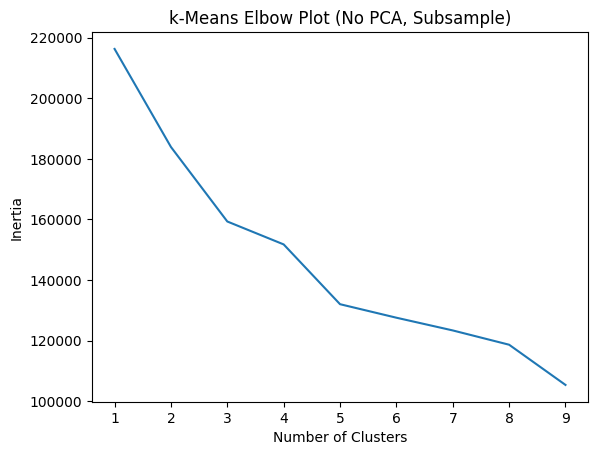

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mglearn

# Convert subsample of training set DataFrame to numpy array
sub_val = subsample.values

# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(sub_val)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("k-Means Elbow Plot (No PCA, Subsample)")
plt.show()

Although the elbow visualization is not conclusive, inertia decreases sharply from k = 1 to k = 3, and slows thereafter. Given this decrease, I selected k = 3 for the non-PCA clustering

Text(0.5, 1.0, 'k-Means Clustering Without PCA (Subsample)')

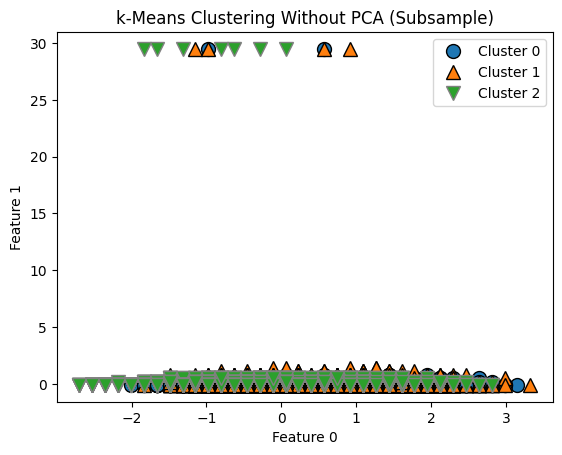

In [55]:
# instantiate an instance of k-Means
kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_val)

# get assignments (labels)
assignments=kmeans.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(sub_val[:, 0], sub_val[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("k-Means Clustering Without PCA (Subsample)")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


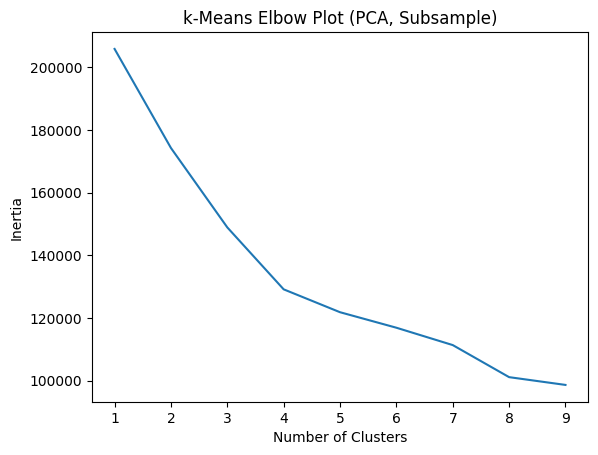

In [59]:
# apply PCA to the subsample, using PCA fit earlier
X_sub_pca = pca_95.transform(sub_val)

# elbow visualization
inertiaVals = {}

for k in range(1, 10):
    kmeansK = KMeans(n_clusters=k, max_iter=1000).fit(X_sub_pca)
    inertiaVals[k] = kmeansK.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("k-Means Elbow Plot (PCA, Subsample)")
plt.show()

Based on the elbow visualization, inertia decreases sharply from k = 1 to k = 4, and slows thereafter. Given this decrease, I selected k = 4 for the PCA clustering

Text(0.5, 1.0, 'k-Means Clustering with PCA (Subsample)')

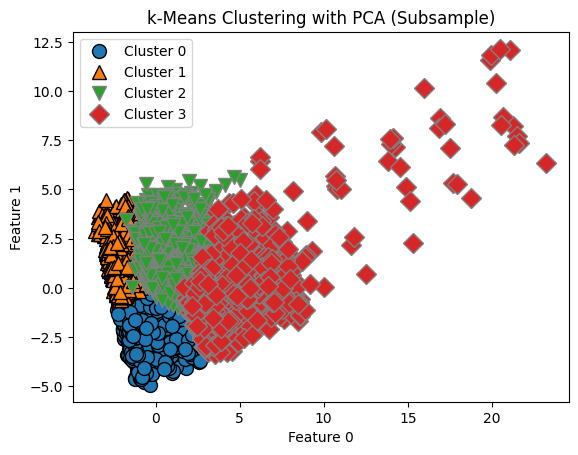

In [36]:
# instantiate an instance of k-Means
kmeans_pca = KMeans(n_clusters=4, random_state=66)
kmeans_pca.fit(X_sub_pca)

# get assignments (labels)
assignments_pca = kmeans_pca.labels_

# plot a scatter matrix of the results
mglearn.discrete_scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], assignments_pca)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("k-Means Clustering with PCA (Subsample)")

## Aggolmerate/Hierarchical

### Without PCA

Text(0.5, 1.0, 'Agglomerative Clustering without PCA (Subsample)')

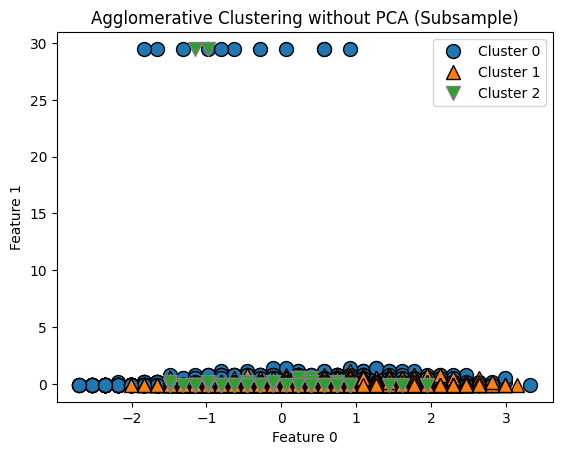

In [41]:
# without PCA
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predictsub_val()

mglearn.discrete_scatter(sub_val[:, 0], sub_val[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Agglomerative Clustering without PCA (Subsample)")

### With PCA

Text(0.5, 1.0, 'Agglomerative Clustering with PCA (Subsample)')

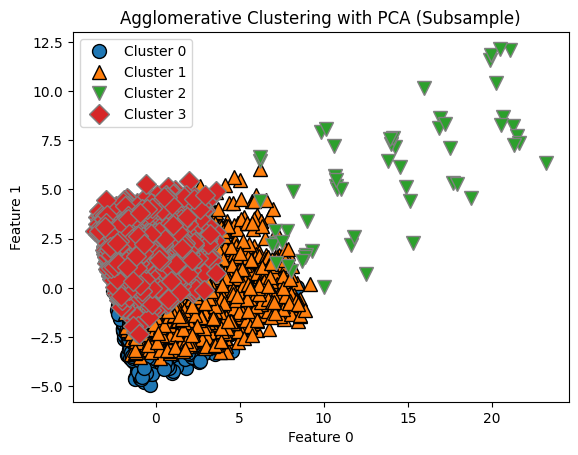

In [40]:
# with PCA
agg = AgglomerativeClustering(n_clusters=4)
assignment = agg.fit_predict(X_sub_pca)

mglearn.discrete_scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Agglomerative Clustering with PCA (Subsample)")

## DBSCAN

Text(0, 0.5, 'Feature 1')

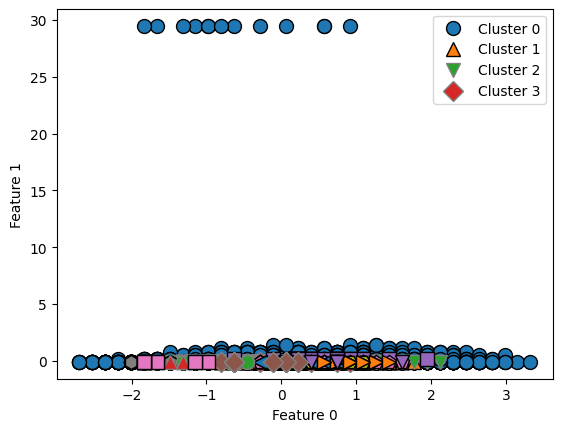

In [67]:
from sklearn.cluster import DBSCAN

# without PCA
dbscan = DBSCAN(min_samples=10,eps=1.0)
clusters = dbscan.fit_predict(sub_val)

# plot the cluster assignments
mglearn.discrete_scatter(sub_val[:, 0], sub_val[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

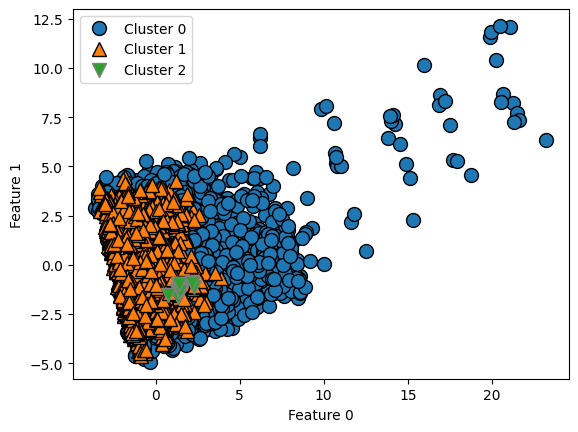

In [69]:
# with PCA

dbscan = DBSCAN(min_samples=15,eps=1.5)
clusters = dbscan.fit_predict(X_sub_pca)

# plot the cluster assignments
mglearn.discrete_scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")